In [11]:
# Imports
import torch


torch.cuda.empty_cache()

from torch.nn.functional import interpolate


from hr_dv2 import HighResDV2, torch_pca
import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize, AsinhNorm, LogNorm
from skimage.color import rgb2gray

torch.manual_seed(0)
np.random.seed(0)

from featup.util import norm, unnorm
use_norm = True

In [12]:
C = 384
L = 518

In [13]:
def load_img(path: str) -> tuple[torch.Tensor, np.ndarray]:
    temp_img = Image.open(path)
    h, w = temp_img.height, temp_img.width
    transform = tr.get_input_transform(L, L)
    tensor, img = tr.load_image(path, transform)
    H, W = img.height, img.width
    return tensor, np.array(img)

In [14]:
inp_tensor, inp_arr = load_img('fig_data/cones_input.jpg')
targ_tensor, targ_arr = load_img('fig_data/cones_target.jpg')

inp_tensor, targ_tensor = inp_tensor.cuda(), targ_tensor.cuda()

In [15]:
def add_inset_zoom(xywh: list[int], fig_xywh: list[float], img_arr: np.ndarray, ax ) -> object:
    x0, y0, w, h = xywh
    fx, fy, fw, fh = fig_xywh
    H, W, C = img_arr.shape
    inset_data = np.zeros_like(img_arr)
    inset_data[y0:y0+h, x0:x0+w, :] = img_arr[y0:y0+h, x0:x0+w, :]
    extent = (0, H, W, 0)
    # 418 / 518, 0 / 518, 150 / 518, 150 / 518
    axin = ax.inset_axes(
        fig_xywh, xlim=(x0, x0+w), ylim=(y0, y0+h))
    axin.set_axis_off()
    axin.imshow(inset_data)
    ax.indicate_inset_zoom(axin, edgecolor="r", lw=2)
    axin.set_ylim((y0 + h, y0))
    return axin


In [24]:
net = HighResDV2("dinov2_vits14_reg", 7, dtype=torch.float16) #dino_vits8 #dinov2_vits14_reg
net.interpolation_mode = 'nearest-exact'
net.cuda()

fwd_shift, inv_shift = tr.get_shift_transforms([1, 2, 3, 4], 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


In [25]:
C = net.feat_dim

In [26]:
out = [] # format si, st, oi, ot

for i in range(3):
    if i == 0:
        net.set_transforms([], [])
    elif i == 1:
        net.set_transforms(fwd, inv)
    else:
        net = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm)
        net.cuda()

    for img_tensor in [inp_tensor, targ_tensor]:
        if i == 2:
            tensor = img_tensor.unsqueeze(0)

        else:
            tensor = img_tensor
        feats = net.forward(tensor)
        if i == 2:
            feats = interpolate(feats, (L, L))
        feats_np = tr.to_numpy(feats)
        out.append(feats_np)

Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [19]:
def get_most_similar_point(qx: int, qy: int, inp_2D: np.ndarray, flat_target: np.ndarray) -> tuple[int, int, np.ndarray]:
    query_vec = inp_2D[:, qy, qx]
    sim = np.dot(query_vec, flat_target)
    sim_2D = sim.reshape((L, L))

    max_sim_idx = np.argmax(sim_2D)
    SY, SX = max_sim_idx // L, max_sim_idx % L  
    return SX, SY, sim_2D


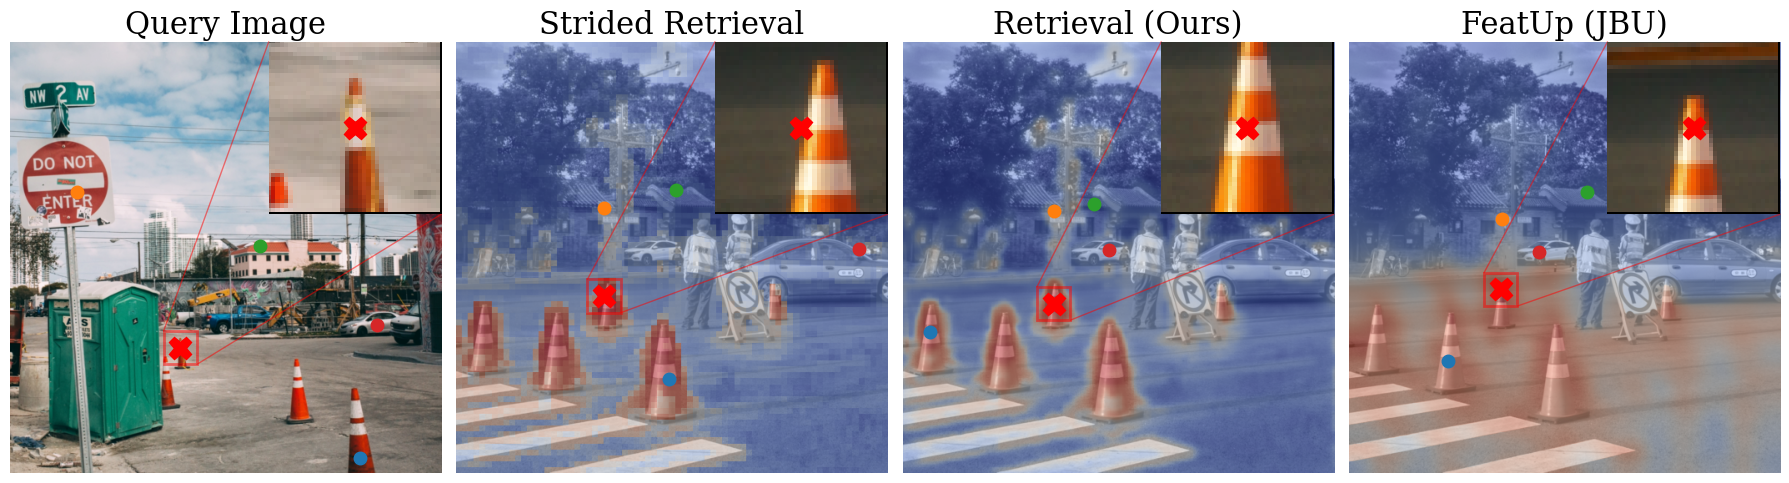

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=4)

fig.set_size_inches(18, 8)
plt.rcParams["font.family"] = "serif"

cross_s, dot_s = 16, 18

titles = ["Query Point", "Query Image", "Strided Retrieval", "Retrieval (Ours)", "FeatUp (JBU)", "foo"]
for i in range(-1, 3):
    ax = axs[i+1]#axs[(i + 2) // 2, (i + 2) % 2]
    ax.set_title(titles[i + 2], fontsize=22)
    ax.set_axis_off()
    if i == -1:
        ax.imshow(inp_arr)
        QX, QY = 204, 367
        ax.plot(QX, QY, marker="X", ms=cross_s, color='r')

        other_points = [(420, 500), (80, 180), (300, 245), (440, 340)]

        for p in other_points:
            ax.plot(p[0], p[1], marker=".", ms=dot_s)

        xywh = [QX - 20, QY - 20, 40, 40]
        fxywh = [0.6, 0.6, 0.4, 0.4]

        axin = add_inset_zoom(xywh, fxywh, inp_arr, ax)
        axin.plot(QX, QY, marker="X", ms=cross_s, color='r')
    else:
        SX, SY, sim_2D = get_most_similar_point(QX, QY, out[i * 2], out[(i * 2) + 1].reshape((C, -1)))

        for p in other_points:
            sx, sy, _ = get_most_similar_point(p[0], p[1], out[i * 2], out[(i * 2) + 1].reshape((C, -1)))
            ax.plot(sx, sy, marker=".", ms=dot_s)
        
        ax.plot(SX, SY, marker="X", ms=cross_s, color='r')
        norm = Normalize()
        colors = colormaps['coolwarm'](norm(sim_2D))
        #greyscale_arr = np.expand_dims(rgb2gray(targ_arr), -1)

        greyscale_pil = Image.fromarray(targ_arr).convert('L').convert('RGB')
        rgb_cmap = Image.fromarray((colors[:, :, :3] * 255).astype(np.uint8))


        img = Image.blend(greyscale_pil, rgb_cmap, 0.5)
        ax.imshow(img)

        txywh = [SX - 20, SY - 20, 40, 40]
        tfxywh = [0.6, 0.6, 0.4, 0.4]
        t_axin = add_inset_zoom(txywh, tfxywh, targ_arr, ax)
        t_axin.plot(SX, SY, marker="X", ms=cross_s, color='r')
plt.tight_layout()
plt.savefig('fig_out/retrieval_d2_s7.png')

In [27]:
net = HighResDV2("dino_vits8", 4, dtype=torch.float16) #dino_vits8 #dinov2_vits14_reg
net.interpolation_mode = 'nearest-exact'
net.cuda()

fwd_shift, inv_shift = tr.get_shift_transforms([1, 2], 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


In [31]:
out = [] # format si, st, oi, ot

for i in range(2):
    if i == 0:
        net.set_transforms([], [])
    elif i == 1:
        net.set_transforms(fwd, inv)

    for img_tensor in [inp_tensor, targ_tensor]:
        tensor = img_tensor
        feats = net.forward(tensor)
        feats_np = tr.to_numpy(feats)
        out.append(feats_np)

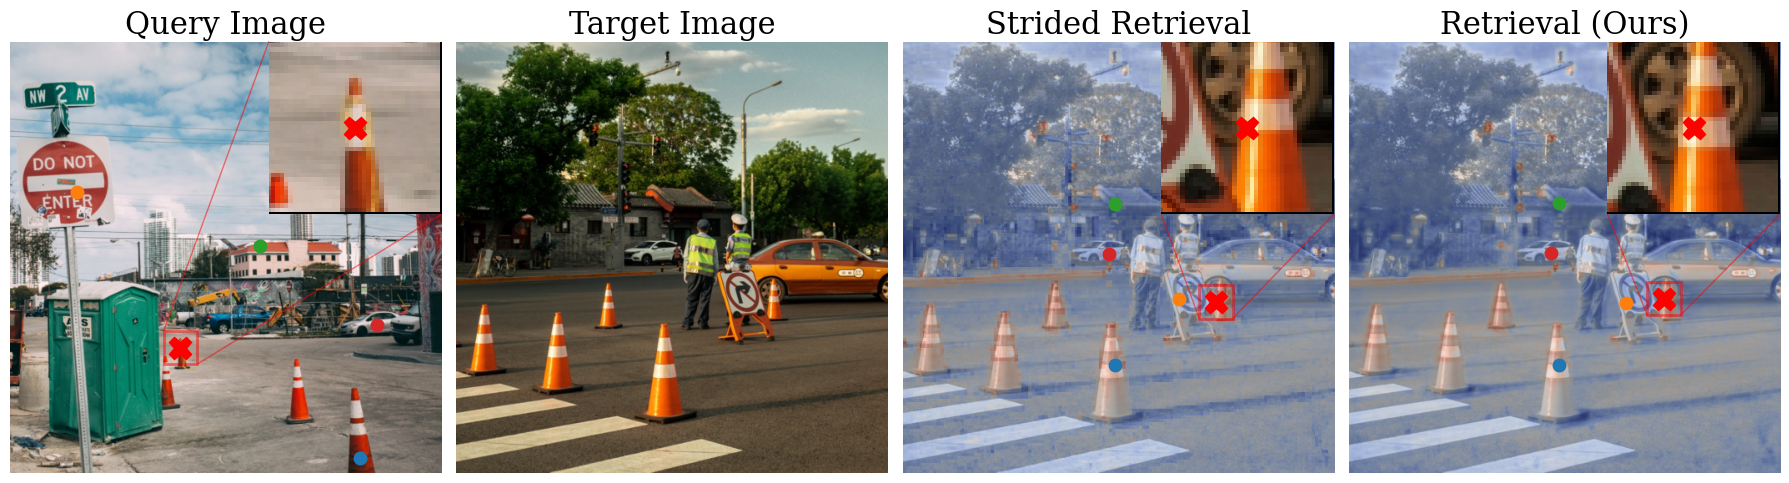

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=4)

fig.set_size_inches(18, 8)
plt.rcParams["font.family"] = "serif"

cross_s, dot_s = 16, 18

titles = ["Query Image", "Target Image", "Strided Retrieval", "Retrieval (Ours)"]
for i in range(-2, 2):
    ax = axs[i+2]#axs[(i + 2) // 2, (i + 2) % 2]
    ax.set_title(titles[i + 2], fontsize=22)
    ax.set_axis_off()
    if i == -2:
        ax.imshow(inp_arr)
        QX, QY = 204, 367
        ax.plot(QX, QY, marker="X", ms=cross_s, color='r')

        other_points = [(420, 500), (80, 180), (300, 245), (440, 340)]

        for p in other_points:
            ax.plot(p[0], p[1], marker=".", ms=dot_s)

        xywh = [QX - 20, QY - 20, 40, 40]
        fxywh = [0.6, 0.6, 0.4, 0.4]

        axin = add_inset_zoom(xywh, fxywh, inp_arr, ax)
        axin.plot(QX, QY, marker="X", ms=cross_s, color='r')
    elif i == -1:
        ax.imshow(targ_arr)
    else:
        SX, SY, sim_2D = get_most_similar_point(QX, QY, out[i * 2], out[(i * 2) + 1].reshape((C, -1)))

        for p in other_points:
            sx, sy, _ = get_most_similar_point(p[0], p[1], out[i * 2], out[(i * 2) + 1].reshape((C, -1)))
            ax.plot(sx, sy, marker=".", ms=dot_s)
        
        ax.plot(SX, SY, marker="X", ms=cross_s, color='r')
        norm = Normalize()
        colors = colormaps['coolwarm'](norm(sim_2D))
        #greyscale_arr = np.expand_dims(rgb2gray(targ_arr), -1)

        greyscale_pil = Image.fromarray(targ_arr).convert('L').convert('RGB')
        rgb_cmap = Image.fromarray((colors[:, :, :3] * 255).astype(np.uint8))


        img = Image.blend(greyscale_pil, rgb_cmap, 0.5)
        ax.imshow(img)

        txywh = [SX - 20, SY - 20, 40, 40]
        tfxywh = [0.6, 0.6, 0.4, 0.4]
        t_axin = add_inset_zoom(txywh, tfxywh, targ_arr, ax)
        t_axin.plot(SX, SY, marker="X", ms=cross_s, color='r')
plt.tight_layout()
plt.savefig('fig_out/retrieval_d_s4.png')